# Convecção, difusão e a equação de Burgers

* PET - Física UFRN
* Petiano: Gabriel Wendell Celestino Rocha
* Data: 07 de Abril de 2021

O objetivo deste `Notebook` é servir como uma introdução à Dinâmica de Fluídos Computacional (CFD). Neste `Notebook` será abordado os fenômenos da convecção (linear e não linear) e difusão bem como a combinação entre o movimento de uma onda linear com a difusão linear (também conhecido como equação de Burgers) em uma e duas dimensões.

Além disso, este `Notebook` será dividido em duas partes: modelo unidimensional e modelo bidimensional. Na primeira parte iremos analisar os fenômenos da convecção linear e não linear, difusão e avaliar a equação de Burgers para um modelo unidimensional. Na segunda parte será feita a mesma análise feita na primeira parte (desde convecção linear até a equação de Burgers), porém iremos avaliar um modelo bidimensional.

## Pré-requisitos

Recomenda-se que o leitor possua as habilidades básicas de programação, como os conceitos de iterações, chamadas de função e assim por diante. Não é necessário que o leitor seja um conhecedor de todos os conceitos de CFD, uma vez que este `Notebook` visa servir como uma introdução à mesma.

### Importando as bibliotecas necessárias

In [1]:
from sympy.utilities.lambdify import lambdify  # Somente na parte 1.
from mpl_toolkits.mplot3d import Axes3D        # Somente na parte 2.
import matplotlib.pyplot as plt
import sympy as sy                             # Somente na parte 1.
import numpy as np
import time, sys

%matplotlib notebook

Com relação à biblioteca `SymPy` que importamos acima, `SymPy` (clique [aqui](https://docs.sympy.org/latest/index.html) para checar a sua documentação) é uma biblioteca matemática simbólica para Python. Tal biblioteca possui muitas das mesmas funcionalidades matemáticas simbólicas do Mathematica com o benefício adicional de podermos produzir facilmente traduzir seus resultados de volta em nossos cálculos Python (além de ser gratuito e de código aberto).

Você pode instalar a biblioteca `SymPy` usando o `pip` executando o seguinte comando no seu terminal:

`pip install sympy`

Vamos usar também a magic extension `%version_information` do IPython para gerar um quadro com as informações sobre quais versões das bibliotecas que foram usadas para executar este Notebook.

In [2]:
%load_ext version_information
%version_information Matplotlib, SymPy, Numpy

Software versions
Python 3.7.5 64bit [MSC v.1916 64 bit (AMD64)]
IPython 7.10.0
OS Windows 10 10.0.19041 SP0
Matplotlib 3.1.2
SymPy 1.4
Numpy 1.19.0
Sun Mar 28 14:50:53 2021 Hora Padrão de Buenos Aires

## Modelo unidimensional

### 1.1 Convecção Linear

A equação de convecção linear unidimensional (1D) é o modelo mais simples e básico que pode ser usado para aprender sobre CFD. Mas apesar de sua simplicidade, podemos extrair muitas informações que nos ajudarão a compreender modelos convectivos de dimensões maiores:

$$\frac{\partial u}{\partial t}+c\frac{\partial u}{\partial x}=0$$

Com determinadas condições iniciais (entendidas como *onda*), a equação representa a propagação inicial de uma onda com velocidade $c$, sem mudança de forma. Seja a condição inicial $u(x,0)=u_{0}(x)$. Então a solução exata da equação acima será $u(x,t)=u_{0}(x-ct)$.

Podemos então discretizar a equação acima no espaço e no tempo, para isso usamos o esquema das diferenças progressivas para o a derivada temporal e as diferenças regressivas para a derivada espacial. Considere discretizar a coordenada espacial $x$ em pontos que indexamos de $i=0$ até $N$ e avançar em intervalos de tempo discretos de tamanho $\Delta t$.

A partir da definição de derivada (removendo o limite), sabemos que:

$$\frac{\partial u}{\partial x}\approx\frac{u(x+\Delta x)-u(x)}{\Delta x}$$

Nossa equação discreta, então, assume a seguinte forma:

$$\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}+c\frac{u_{i}^{n}-u_{i-1}^{n}}{\Delta x}=0$$

Onde $n$ e $n+1$ são duas etapas consecutivas no tempo, enquanto $i-1$ e $i$ são dois pontos vizinhos da coordenada $x$ discretizada. Se houver condições iniciais fornecidas, então a única incógnita nesta discretização é $u_{i}^{n+1}$. Podemos resolver nossa incógnita para obter uma equação que nos permite avançar no tempo, da seguinte maneira:

$$u_{i}^{n+1}=u_{i}^{n}-c\frac{\Delta t}{\Delta x}(u_{i}^{n}-u_{i-1}^{n})$$

Agora vamos tentar implementar tal resultado no Python. Agora vamos definir algumas variáveis; desejamos definir uma grade de pontos uniformemente espaçados dentro de um domínio espacial que possui 2 unidades de comprimento de largura, ou seja, $x_{i}\in(0,2)$. Vamos definir uma variável `nx`, que será o número de pontos de grade que desejamos e `dx` será a distância entre qualquer par de pontos de grade adjacentes.

In [3]:
nx = 41
dx = 2/(nx-1)
nt = 20
dt = .025
c = 1

Também precisamos definir as nossas condições iniciais. A velocidade inicial $u_{0}$ é dada como $u=2$ no intervalo $0.5\leq x\leq1$ e $u=1$ em qualquer ponto em $(0,2)$ (em outras palavras, é uma função chápeu).

In [4]:
u = np.ones(nx)
u[int(.5/dx):int(1/dx+1)] = 2
print(u)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Vamos plotar e avaliar as condições iniciais de nosso problema. Como de costume, definimos uma função para melhorar um pouco a estética dos plots:

In [5]:
def opt_plot():
    plt.grid(True, linestyle=':', color='0.50')
    plt.minorticks_on()
    plt.tick_params(axis='both',which='minor', direction = "in",
                    top = True,right = True, length=5,width=1,labelsize=15)
    plt.tick_params(axis='both',which='major', direction = "in",
                    top = True,right = True, length=8,width=1,labelsize=15)

Agora vamos plotar o gráfico:

<IPython.core.display.Javascript object>


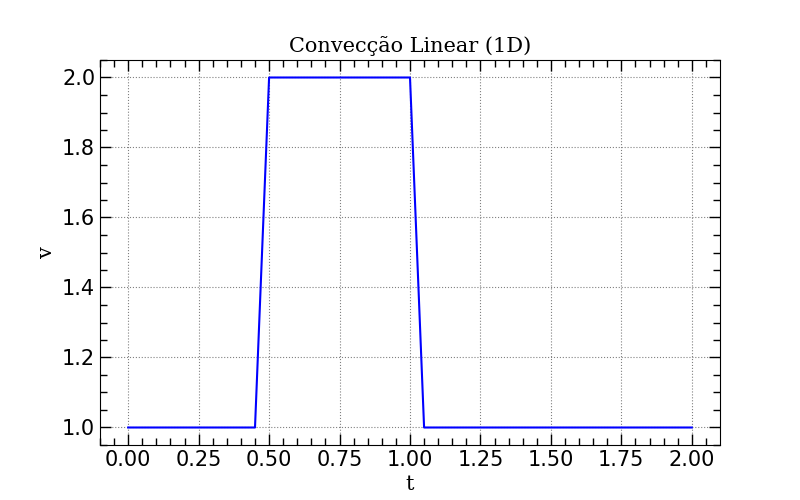

In [6]:
plt.figure(figsize=(8,5))

plt.plot(np.linspace(0, 2, nx), u, color='blue')
plt.title('Convecção Linear (1D)', family='serif', fontsize=15)
plt.xlabel('t', family='serif', fontsize=15)
plt.ylabel('v', family='serif', fontsize=15)
opt_plot()

plt.savefig('Convecção Linear 1D - Função chapéu.png')

Note que a função chápeu não possui lados perfeitamente retos. Agora vamos implementar a discretização da equação de convecção usando um esquema de diferenas finitas.

Para cada elementos de nosso array `u`, precisaremos realizar a seguinte operação:

$$u_{i}^{n+1}=u_{i}^{n}-c\frac{\Delta t}{\Delta x}(u_{i}^{n}-u_{i-1}^{n})$$

Armazenaremos o resultado em um novo array (temporário) `un`, que será a solução $u$ para a próxima etapa de tempo. Repetiremos esta operação por tantos intervalos de tempo quanto especificamos e então poderemos ver o quão longe a onda se propagou convectivamente. Então, podemos pensar que temos duas operações iterativas: uma no espaço e outra no tempo.

In [7]:
for n in range(nt):
    un = u.copy()
    for i in range(1,nx):
        u[i] = un[i] - c *dt/dx* (un[i] - un[i-1])

Agora vamos plotar o array `u` avançando com o tempo:

<IPython.core.display.Javascript object>


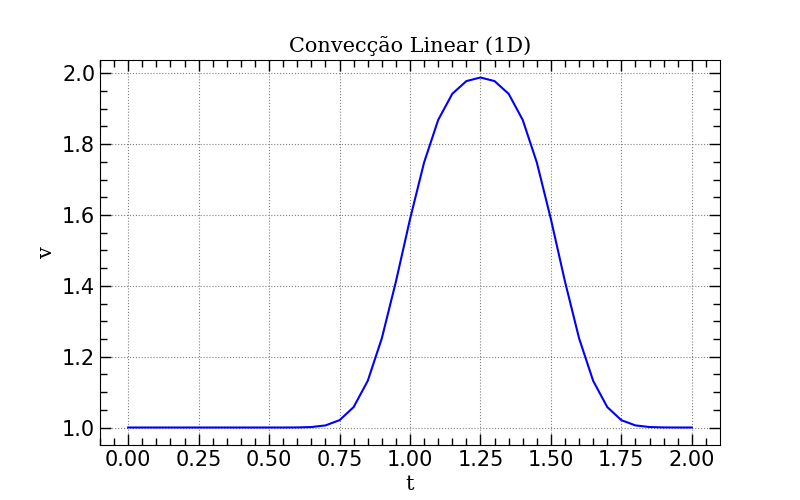

In [8]:
plt.figure(figsize=(8,5))

plt.plot(np.linspace(0, 2, nx), u, color='blue')
plt.title('Convecção Linear (1D)', family='serif', fontsize=15)
plt.xlabel('t', family='serif', fontsize=15)
plt.ylabel('v', family='serif', fontsize=15)
opt_plot()

plt.savefig('Convecção liner 1D.png')

Note que nossa função chapéu se deslocou para a direita e deixou de se assemelhar a um chapéu. Um questionamento interessante que será deixado a cargo do leitor que se estiver disposto a refletir sobre.

### 1.2. Convecção não linear 

 Agora vamos implementar o modelo de convecção não linear usando os mesmos métodos da seção anterior. Desta vez, vamos tramabalhar com a equação da convecção 1D abaixo:

$$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}=0$$

Em vez de um fator constante $c$ multiplicando o segundo termo, agora temos a solução $u$ o multiplicando. Assim, o segundo termo da equaçã passa a ser não linear. Vamos usar a mesma discretização da seção 1.1 - diferenças progressivas e regressivas no espaço. Nossa equação discretizada será:

$$\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}+u_{i}^{n}\frac{u_{i}^{n}-u_{i-1}^{n}}{\Delta x}=0$$

Resolvendo para a única incógnita, $u_{i}^{n+1}$, obtemos:

$$u_{i}^{n+1}=u_{i}^{n}-u_{i}^{n}\frac{\Delta t}{\Delta x}(u_{i}^{n}-u_{i-1}^{n})$$

Analogamente ao caso linear, declaramos algumas variáveis que determinam a discretização no espaço e no tempo (o leitor interessado pode experimentar alterar tais parâmetros para avaliar o resultado). Em seguida, criamos a condição inicial $u_{0}$ inicializando o array para a solução definindo a função chapéu:

In [9]:
nx = 41
dx = 2 / (nx - 1)
nt = 20   
dt = .025  

u = np.ones(nx)      
u[int(.5 / dx) : int(1/dx+1)] = 2 

un = np.ones(nx) 

Note que podemos apenas copiar o código usado na subseção 1.1 alterando pouquíssimas coisas:

In [10]:
for n in range(nt):  
    un = u.copy() 
    for i in range(1, nx):
        u[i] = un[i] - un[i] *dt/dx* (un[i] - un[i-1])

Agora plotamos os resultados:

<IPython.core.display.Javascript object>


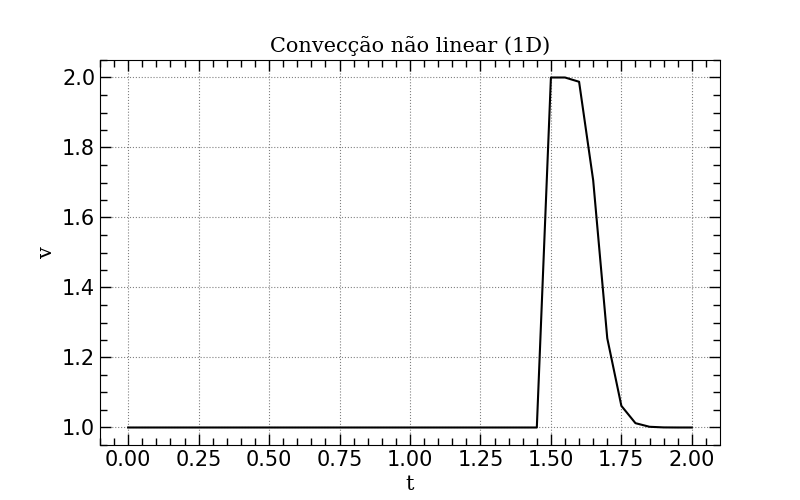

In [11]:
plt.figure(figsize=(8,5))

plt.plot(np.linspace(0, 2, nx), u, color='black')
plt.title('Convecção não linear (1D)', family='serif', fontsize=15)
plt.xlabel('t', family='serif', fontsize=15)
plt.ylabel('v', family='serif', fontsize=15)
opt_plot()

plt.savefig('Convecção não linear 1D.png')

Note que a nossa função chapéu continua a se deslocar para a direita e novamente deixou de se assemelhar à um chapéu, como já era de se esperar.

### 1.3. Difusão

A equação unidimensional da difusão é um resultado conhecido do estudo da Mecânica dos Fluídos. Tal resultado é apresentado abaixo:

$$\frac{\partial u}{\partial t}=\nu\frac{\partial^{2}u}{\partial x^{2}}$$

Primeiramente, note que ao contrário das duas equações abordadas anteriormente, a equação da difusão possui uma derivada de segunda ordem.

#### 1.3.1. Discretizando o termo $\frac{\partial^{2}u}{\partial x^{2}}$

A derivada de segunda ordem pode ser representada geometricamente como a reta tangente à curva dada pela primeira derivada. Discretizaremos a derivada de segunda ordem com um esquema de diferenças centradas: uma combinação de diferenças regressivas e progressivas da primeira derivada. Considere a expansão de Taylor de $u_{i+1}$ e $u_{i-1}$ em torno de $u_{i}$:

$$u_{i+1}=u_{i}+\Delta x\frac{\partial u}{\partial x}\Bigg|_{i}+\frac{\Delta x^{2}}{2!}\frac{\partial^{2}u}{\partial x^{2}}\Bigg|_{i}+\frac{\Delta x^{3}}{3!}\frac{\partial^{3}u}{\partial x^{3}}\Bigg|_{i}+O(\Delta x^{4})$$

$$u_{i-1}=u_{i}-\Delta x\frac{\partial u}{\partial x}\Bigg|_{i}+\frac{\Delta x^{2}}{2!}\frac{\partial^{2}u}{\partial x^{2}}\Bigg|_{i}-\frac{\Delta x^{3}}{3!}\frac{\partial^{3}u}{\partial x^{3}}\Bigg|_{i}+O(\Delta x^{4})$$

Se adicionarmos essas duas expansões, notaremos que os termos de derivada ímpar se anularão. Se negligenciarmos quaisquer termos de ordem $O(\Delta x^{4})$ ou superior (uma vez que tais termos são demasiadamente diminutos), então podemos rearranjar a soma destas duas expansões para resolvermos a segunda derivada em análise.

$$u_{i+1}+u_{i-1}=2u_{i}+\Delta x^{2}\frac{\partial^{2}u}{\partial x^{2}}\Bigg|_{i}+O(\Delta x^{4})$$

Rearranjando nossa equação para resolver $\frac{\partial^{2}u}{\partial x^{2}}\Big|_{i}$ obtemos como resultado:

$$\frac{\partial^{2}u}{\partial x^{2}}=\frac{u_{i+1}-2u_{i}+u_{i-1}}{\Delta x^{2}}+O(\Delta x^{2})$$

#### 1.3.2. Retornando à equação da difusão...

Agora podemos escrever a versão discretizada da equação de difusão unidimensional:

$$\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\nu\frac{u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n}}{\Delta x^{2}}$$

Assim como ocorrerá anteriormente, nota-se que, uma vez que possuímos a condição inicial, a única incógnita será o termo $u_{i}^{n+1}$, então reorganizamos a equação resolvendo nossa incógnita:

$$u_{i}^{n+1}=u_{i}^{n}+\frac{\nu\Delta t}{\Delta x^{2}}(u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n})$$

A equação discreta mostrada acima nos permite escrever um programa para avançar uma solução no tempo. Mas precisaremos uma condição inicial. Vamos usar a nossa função favorita até o presente momento: a função chapéu!

In [12]:
nx = 41
dx = 2 / (nx - 1)
nt = 20    
nu = 0.3   
sigma = .2 
dt = sigma * dx**2 / nu 

u = np.ones(nx)      
u[int(.5 / dx):int(1 / dx + 1)] = 2 

un = np.ones(nx) 

for n in range(nt):  
    un = u.copy() 
    for i in range(1, nx - 1):
        u[i] = un[i] + nu * dt / dx**2 * (un[i+1] - 2 * un[i] + un[i-1])

Por fim, vamos ao plot:

<IPython.core.display.Javascript object>


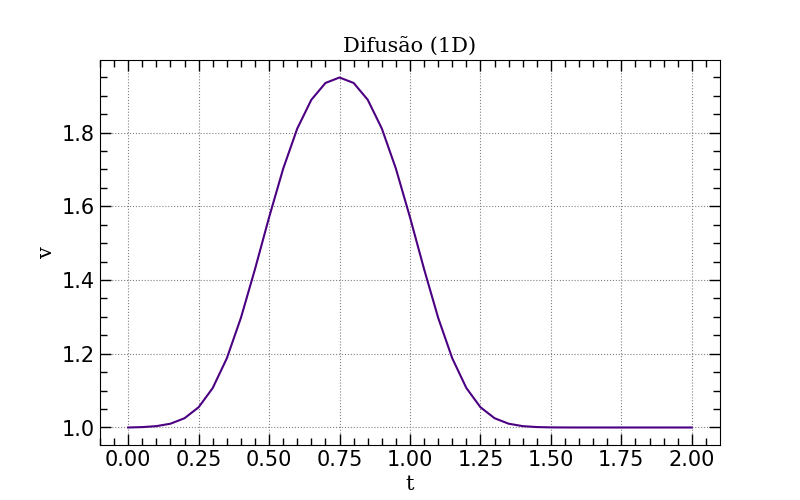

In [13]:
plt.figure(figsize=(8,5))

plt.plot(np.linspace(0, 2, nx), u, color='indigo')
plt.title('Difusão (1D)', family='serif', fontsize=15)
plt.xlabel('t', family='serif', fontsize=15)
plt.ylabel('v', family='serif', fontsize=15)
opt_plot()

plt.savefig('Difusão 1D.png')

O comportamente acima já era esperado um vez que, nossa equação claramente não era linear.

### 1.4. Equação de Burgers

A equação de Burgers é um resultado obtido por meio da combinação do movimento de onda não linear com a difusão linear e é o modelo mais simples para analisar o efeito combinado da advecção e difusão não linear. A presença de um termo relativo à viscosidade ajuda a suprimir a quebra de onda e a suavizar descontinuidades de choque. Você pode consultar o artigo presente na referência [3] ou clicando [aqui](https://www.iist.ac.in/sites/default/files/people/IN08026/Burgers_equation_viscous.pdf) para mais informações acerca da equação de Burgers. Além disso, o artigo presente na referência [4] além de mostrar como resolver numericamente a equação de Burgers mostra também uma implementação da mesma no MATLAB (clique [aqui](https://www.mathworks.com/products/matlab.html) para checar o site oficial do MATLAB).

A equação de Burgers em uma dimensão espacial pode ser escrita na seguinte forma:

$$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}=\nu\frac{\partial^{2}u}{\partial x^{2}}$$

Note que a equação acima pe uma combinação da difusão com a convecção não linear.

Podemos discretizá-la usando os métodos apresentados nas seções anteriores. Usando diferenças progressivas para o tempo, a diferença retroativa para o espaço e o método apresentado de 2ª ordem para as derivadas secundárias resulta:

$$\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}+u_{i}^{n}\frac{u_{i}^{n}-u_{i-1}^{n}}{\Delta x}=\nu\frac{u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n}}{\Delta x^{2}}$$

Assim como antes, uma vez que temos a condição inicial, a única incógnita passa a ser $u_{i}^{n+1}$. Avançaremos no tempo da seguinte forma:

$$u_{i}^{n+1}=u_{i}^{n}-u_{i}^{n}\frac{\Delta t}{\Delta x}(u_{i}^{n}-u_{i-1}^{n})+\nu\frac{\Delta t}{\Delta x^{2}}(u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n})$$

#### 1.4.1. Condições iniciais e de limite

Para examinar algumas propriedades interessantes da equação de Burgers, é útil usar condições iniciais e de contorno diferentes das que usamos nas seções anteriores. Nossa condição inicial para esse problema será:

$$u=-\frac{2\nu}{\phi}\frac{\partial \phi}{\partial x}+4$$

$$\phi=\exp\Bigg[\frac{-x^{2}}{4\nu}\Bigg]+\exp\Bigg[\frac{-(x-2\pi)^{2}}{4\nu}\Bigg]$$

Este possui uma solução analítica, que é dada por:

$$u=-\frac{2\nu}{\phi}\frac{\partial\phi}{\partial x}+4$$

$$\phi=\exp\Bigg[\frac{-(x-4t)^{2}}{4\nu(t+1)}\Bigg]+\exp\Bigg[\frac{-(x-4t-2\pi)^{2}}{4\nu(t+1)}\Bigg]$$

Nossa condição limite será:

$$u(0)=u(2\pi)$$

Isso é chamado de condição limite *periódica*. Tome cuidado, pois isto pode causar um pouco de confusão e dores de cabeça se não agir com cuidado.

#### 1.4.2. Economizando tempo SymPy

A condição inicial que estamos usando para a equação de Burguers pode ser um tanto quanto difícil de se avaliar manualmente. A derivada $\frac{\partial\phi}{\partial x}$ não chega a ser de dificuldade extrema, mas seria fácil acabar esquecendo de adicionar um sinal ou um fator de $x$ em algum lugar. Dessa forma, vamos usar o `SymPy` para nos auxiliar nessa empreitada.

Vamos informar ao `SymPy` que desejamos que todas as suas saídas sejam renderizadas em $\LaTeX$:

In [14]:
sy.init_printing(use_latex=True)

Começamos configurando variáveis simbólicas para as três variáveis em nossa condição inicial e, em seguida, digitamos a equação completa para $\phi$. Devemos obter uma versão bem renderizada de nossa equação $\phi$:

In [15]:
x, nu, t = sy.symbols('x nu t')
phi = (sy.exp(-(x - 4 * t)**2 / (4 * nu * (t + 1))) +
       sy.exp(-(x - 4 * t - 2 * sy.pi)**2 / (4 * nu * (t + 1))))
phi

Talvez seja um pouco pequeno, mas aparenta estar correto. Agora, avaliar nossa derivada parcial $\frac{\partial\phi}{\partial x}$ se torna uma tarefa trivial:

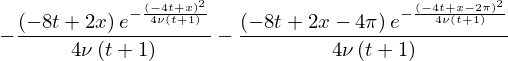

In [16]:
phiprime = phi.diff(x)
phiprime

Caso você não deseje visualizar a versão renderizada, basta usar o comando `print` do Python:

In [17]:
print(phiprime)

-(-8*t + 2*x)*exp(-(-4*t + x)**2/(4*nu*(t + 1)))/(4*nu*(t + 1)) - (-8*t + 2*x - 4*pi)*exp(-(-4*t + x - 2*pi)**2/(4*nu*(t + 1)))/(4*nu*(t + 1))


#### 1.4.3. E agora?

Agora que possuímos uma versão Pythônica de nossa derivada, podemos terminar de escrever a equação de condição inicial completa e então traduzi-la em uma expressão Python utilizável. Para isso, usaremos a função `lambdify` (clique [aqui](https://docs.sympy.org/latest/modules/utilities/lambdify.html) para checar a documentação dessa função), que pega uma equação simbólica `SymPy` e a transforma em uma função que pode ser chamada:

In [18]:
u = -2*nu*(phiprime/phi) + 4
print(u)

-2*nu*(-(-8*t + 2*x)*exp(-(-4*t + x)**2/(4*nu*(t + 1)))/(4*nu*(t + 1)) - (-8*t + 2*x - 4*pi)*exp(-(-4*t + x - 2*pi)**2/(4*nu*(t + 1)))/(4*nu*(t + 1)))/(exp(-(-4*t + x - 2*pi)**2/(4*nu*(t + 1))) + exp(-(-4*t + x)**2/(4*nu*(t + 1)))) + 4


Vamos tentar visualizar a nossa equação de condição inicial completa renderizada em $\LaTeX$:

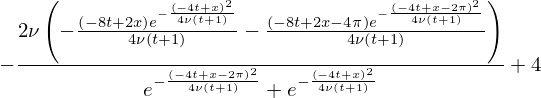

In [19]:
u

#### 1.4.4. Lambdify

Para transformar essa expressão em uma função utilizável, informamos ao `lambdify` quais variáveis solicitar e a função à qual desejamos conectá-las:

In [20]:
ufunc = lambdify((t, x, nu), u)
print(ufunc(1, 4, 3))

3.49170664206445


#### 1.4.5. De volta à equação de Burgers

Agora que configuramos as condições iniciais, podemos prosseguir e concluir a configuração do problema. Incialmente vamos declarar algumas variáveis:

In [21]:
nx = 101
nt = 100
dx = 2*np.pi/(nx - 1)
nu = .07
dt = dx*nu

Definimos nossos espaços:

In [22]:
x = np.linspace(0,2*np.pi,nx)
un = np.empty(nx)
t = 0

u = np.asarray([ufunc(t, x0, nu) for x0 in x])
print(u)

[4.         4.06283185 4.12566371 4.18849556 4.25132741 4.31415927
 4.37699112 4.43982297 4.50265482 4.56548668 4.62831853 4.69115038
 4.75398224 4.81681409 4.87964594 4.9424778  5.00530965 5.0681415
 5.13097336 5.19380521 5.25663706 5.31946891 5.38230077 5.44513262
 5.50796447 5.57079633 5.63362818 5.69646003 5.75929189 5.82212374
 5.88495559 5.94778745 6.0106193  6.07345115 6.136283   6.19911486
 6.26194671 6.32477856 6.38761042 6.45044227 6.51327412 6.57610598
 6.63893783 6.70176967 6.76460125 6.82742866 6.89018589 6.95176632
 6.99367964 6.72527549 4.         1.27472451 1.00632036 1.04823368
 1.10981411 1.17257134 1.23539875 1.29823033 1.36106217 1.42389402
 1.48672588 1.54955773 1.61238958 1.67522144 1.73805329 1.80088514
 1.863717   1.92654885 1.9893807  2.05221255 2.11504441 2.17787626
 2.24070811 2.30353997 2.36637182 2.42920367 2.49203553 2.55486738
 2.61769923 2.68053109 2.74336294 2.80619479 2.86902664 2.9318585
 2.99469035 3.0575222  3.12035406 3.18318591 3.24601776 3.308849

Podemos ainda gerar um gráfico da condição inicial usando a nossa função transformada:

<IPython.core.display.Javascript object>


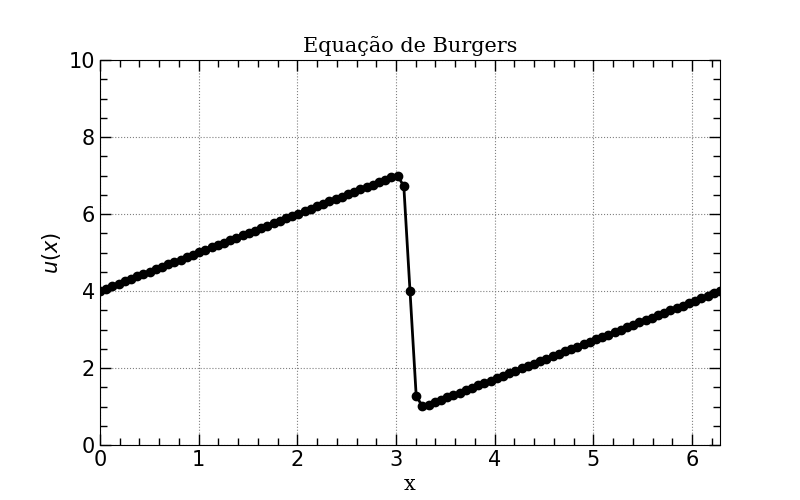

In [23]:
plt.figure(figsize=(8,5))

plt.plot(x, u, color='black', marker='o', lw=2)
plt.xlim([0, 2*np.pi])
plt.ylim([0, 10])
plt.title('Equação de Burgers', family='serif', fontsize=15)
plt.xlabel('x', family='serif', fontsize=15)
plt.ylabel(r'$u(x)$', fontsize=15)
opt_plot()

plt.savefig('Equação de Burgers.png')

Esta definitivamente não é a função chapéu com a qual estivemos lidando até agora. Costuma-se chamar a função acima de "função dente de serra". Vamos prosseguir e avaliar o que acontece com nossa função.

#### 1.4.6. Condições de contorno periódicas

Uma das grandes diferenças entre esta seção e as anteriores é o uso de condições de contorno periódicas. Ao leitor interessado, você pode experimentar retornar às seções 1.1. e 1.2. e tornar as simulações mais longas (basta aumentar `nt`), nesse caso você notará que a onda continuará a se mover para a direita até que a mesma não apareça mais no gráfico. Com condições de contorno periódicas, quando um ponto chega ao lado direito do quadro, ele retorna para a frente do quadro.

Lembre-se da discretização que elaboramos no início desta seção:

$$u_{i}^{n+1}=u_{i}^{n}-u_{i}^{n}\frac{\Delta t}{\Delta x}(u_{i}^{n}-u_{i-1}^{n})+\nu\frac{\Delta t}{\Delta x^{2}}(u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n})$$

Um questionamento interessante para o leitor: o que o termo $u_{i+1}^{n}$ representa quando o índice $i$ já se encontra no final do quadro?

In [24]:
for n in range(nt):
    un = u.copy()
    for i in range(1, nx-1):
        u[i] = un[i] - un[i] * dt / dx *(un[i] - un[i-1]) + nu * dt / dx**2 *\
                (un[i+1] - 2 * un[i] + un[i-1])
    u[0] = un[0] - un[0] * dt / dx * (un[0] - un[-2]) + nu * dt / dx**2 *\
                (un[1] - 2 * un[0] + un[-2])
    u[-1] = u[0]
        
u_analytical = np.asarray([ufunc(nt * dt, xi, nu) for xi in x])

Finalmente, vamos plotar uma comparação entre as soluções analíticas e computacional:

<IPython.core.display.Javascript object>


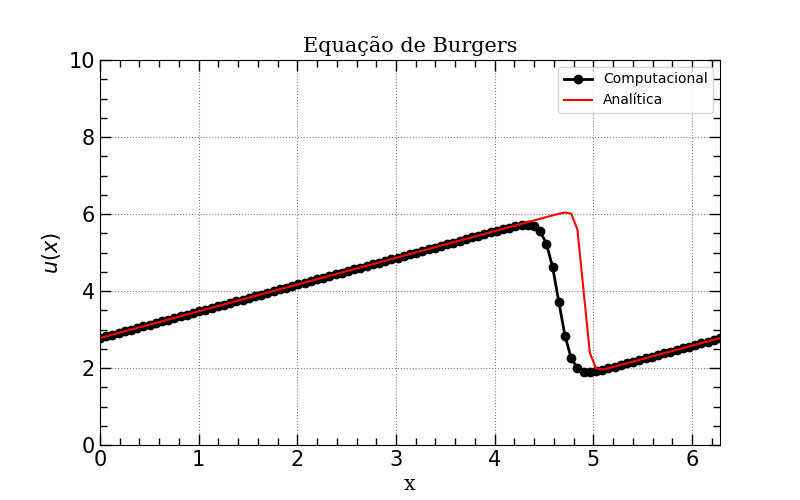

In [25]:
plt.figure(figsize=(8,5))

plt.plot(x, u, color='black', marker='o', lw=2, label='Computacional')
plt.plot(x, u_analytical, color='red', label='Analítica')
plt.xlim([0, 2*np.pi])
plt.ylim([0, 10])
plt.title('Equação de Burgers', family='serif', fontsize=15)
plt.xlabel('x', family='serif', fontsize=15)
plt.ylabel(r'$u(x)$', fontsize=15)
plt.legend(loc='best')
opt_plot()

plt.savefig('Equação de Burgers - Computacional x Analítica.png')

Agora vamos trabalhar com nossas equações em duas dimensões...

$\text{ }$

## Modelo bidimensional

### 2.1. Convecção Linear

Até agora, todo o nosso trabalho teve uma dimensão espacial (seções 1.1 até 1.4). Podemos tirar uma quantidade significativa de informações trabalhando em uma dimensão, mas vamos estender nossos modelos agora para duas dimensões.

Para estender as equações de diferenças finitas unidimensionais para derivadas parciais em duas ou três dimensões, basta aplicar a definição: uma derivada parcial em relação a $x$ é a variação na direção $x$ *na constante* $y$.

No espaço bidimensional, uma grade retangular (uniforme) é definida pelos pontos com coordenadas:

$$x_{i}=x_{0}+i\Delta x$$

$$y_{i}=y_{0}+i\Delta y$$

Agora, defina $u_{i,j}=u(x_{i},y_{j})$ e aplique as equações das diferenças finitas em qualquer variável $x,y$ *aginda separadamente* nos índices $i$ e $j$. Todas as derivadas são baseadas na expansão de Taylor bidimensional de um valor de ponto de malha em torno de $u_{i,j}$.

Portanto, para uma derivada parcial de primeira ordem na direção $x$, uma equação de diferença finita é:

$$\frac{\partial u}{\partial x}\Bigg|_{i,j}=\frac{u_{i+1,j}-u_{i,j}}{\Delta x}+O(\Delta x)$$

e da mesma forma na direção $y$. Dessa forma, podemos escrever as equações de diferenças retroativas, progressivas e centradas para o nosso modelo bidimensional.

A equação diferencial parcial (PDE) bidimensional para a convecção linear pode ser escrita da seguinte forma:

$$\frac{\partial u}{\partial t}+c\frac{\partial u}{\partial x}+c\frac{\partial u}{\partial y}=0$$

Note que a equação acima é exatamente a mesma que usamos na seção 1.1 quando abordamos a convecção linear para o modelo bidimensional, exceto que agora temos duas dimensões espaciais a serem consideradas conforme avançamos no tempo.

Novamente, o intervalo de tempo será discretizado como uma dirença progressiva e ambas as etapas espaciais serão discretizadas como diferenças retroativas. Com implementações unidimensionais, usamos os índices $i$ para denotar o movimento no espaço $($por exemplo, $u_{i}^{n}-u_{i-1}^{n})$. Agora que temos duas dimensões a serem consideradas, precisamos adicionais um segundo índice $j$, para dar conta de todas as informações no regime. Aqui, novamente usaremos $i$ como o índice para nossos valores $x$ e adicionaremos o índice $j$ para rastrear os valores de $y$.

Com isso em mente, nossa discretização da PDE deve ser relativamente direta:

$$\frac{u_{i,j}^{n+1}-u_{i,j}^{n}}{\Delta t}+c\frac{u_{i,j}^{n}-u_{i-1,j}^{n}}{\Delta x}+c\frac{u_{i,j}^{n}-u_{i,j-1}^{n}}{\Delta y}=0$$

Assim como antes, resolvemos para nossa única incognita:

$$\boxed{u_{i,j}^{n+1}=u_{i,j}^{n}-c\frac{\Delta t}{\Delta x}(u_{i,j}^{n}-u_{i-1,j}^{n})-c\frac{\Delta t}{\Delta y}(u_{i,j}^{n}-u_{i,j-1}^{n})}$$

Resolvendo esta equação com as seguintes condições iniciais:

$$u(x,y)= \left\{\begin{matrix} 2,& \mathrm{se }& 0.5\leq x,y\leq1 \\ 1,& \mathrm{se }& {\text{caso contrário}}\end{matrix} \right.$$ 

e com as condições de contorno:

$$u=1, \text{ para}\left\{\begin{matrix} x=0,2 & \\ y=0,1 & \end{matrix} \right.$$

Agora vamos implementar essas equações computacionalmente:

In [26]:
nx = 81
ny = 81
nt = 100
c = 1
dx = 2/(nx-1)
dy = 2/(ny-1)
sigma = .2
dt = sigma*dx

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u = np.ones((ny, nx))
un = np.ones((ny, nx))

# Atribuímos as condições iniciais:
u[int(.5/dy):int(1/dy+1), int(.5/dx):int(1/dx+1)] = 2

Agora vamos plotar as condições iniciais:

<IPython.core.display.Javascript object>


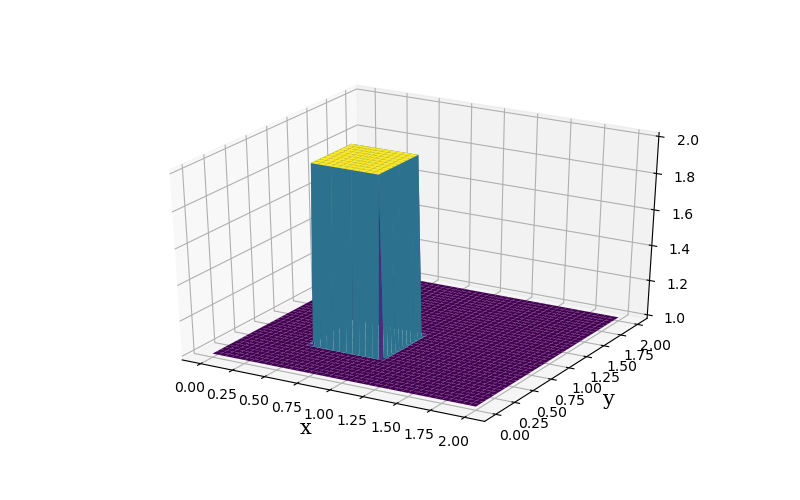

In [27]:
fig = plt.figure(figsize=(8, 5))

ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u[:], cmap=plt.cm.viridis)
ax.set_xlabel('x', family='serif', fontsize=15)
ax.set_ylabel('y', family='serif', fontsize=15)

plt.savefig('Convecção linear 2D - Função chapéu.png')

#### 2.1.1. Notas de plotagem 3D

Para plotar um resultado 3D projetado, certifique-se de ter adicionado a biblioteca `Axes3D`:

`from mpl_toolkits.mplot3d import Axes3D`

Os valores `X` e `Y` que são passados para a função `plot_surface` não são os vetores 1-D `x` e `y`. Para usar as funções de plotagem 2D do matplotlib, é necessário gerar uma grade de valores `x, y` que correspondem a cada coordenada no quadro de plotagem. Esta grade de coordenadas é gerada usando a função `meshgrid` do numpy.

#### 2.1.2. Iterando em duas dimensões

Avaliar a onda em duas dimensões requer o uso de vários for-loops aninhados para cobrir todos os `i`'s e `j`'s. Uma vez que o Python não é uma linguagem muito compilada, pode haver uma lentidão perceptível na execução de um código com múltiplos for-loops. Primeiro tente avaliar o código de convecção 2D e veja quais resultados ele produz.

In [28]:
u = np.ones((ny, nx))
u[int(.5/dy):int(1/dy+1), int(.5/dx):int(1/dx+1)] = 2

# Loop ao longo do número de etapas de tempo:
for n in range(nt+1):
    un = u.copy()
    row, col = u.shape
    
    for j in range(1, row):
        for i in range(1, col):
            u[j,i] = (un[j,i] - (c*dt/dx*(un[j,i] - un[j,i-1])) - (c*dt/dy*(un[j,i] - un[j-1,i])))
            u[0,:] = 1
            u[-1,:] = 1
            u[:,0] = 1
            u[:,-1] = 1

Agora vamos ao plot:

<IPython.core.display.Javascript object>


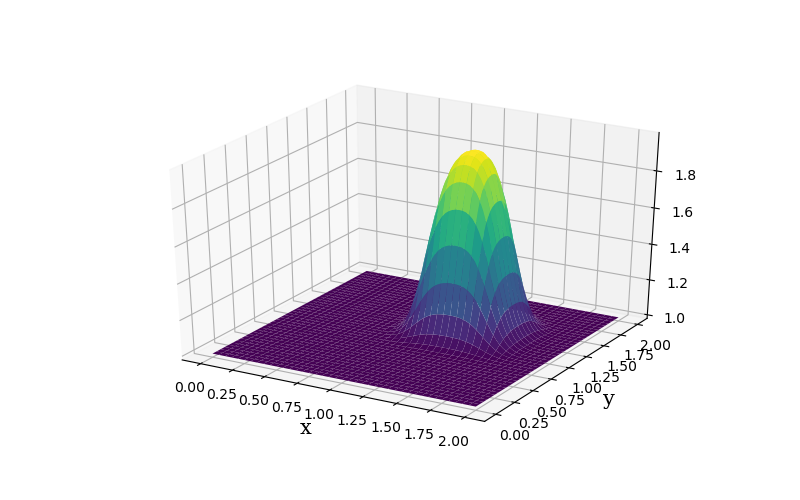

In [29]:
fig = plt.figure(figsize=(8, 5), dpi=100)

ax = fig.gca(projection='3d')
surf2 = ax.plot_surface(X, Y, u[:], cmap=plt.cm.viridis)
ax.set_xlabel('x', family='serif', fontsize=15)
ax.set_ylabel('y', family='serif', fontsize=15)

plt.savefig('Convecção linear 2D.png')

#### 2.1.3. Operações de array

Aqui, o mesmo código de convecção 2D é implementado, mas em vez de usar for-loops aninhados, os mesmos cálculos são avaliados usando operações de arrays.

In [30]:
np.ones((ny,nx))
u[int(.5/dy):int(1/dy+1), int(.5/dx):int(1/dx+1)] = 2

# Loop ao longo do número de etapas de tempo:
for n in range(nt+1):
    un = u.copy()
    u[1:,1:] = (un[1:, 1:] - (c * dt / dx * (un[1:, 1:] - un[1:, :-1])) -(c * dt / dy * (un[1:, 1:] - un[:-1, 1:])))
    u[0,:] = 1
    u[-1,:] = 1
    u[:,0] = 1
    u[:,-1] = 1

Novamente, vamos ao plot:

<IPython.core.display.Javascript object>


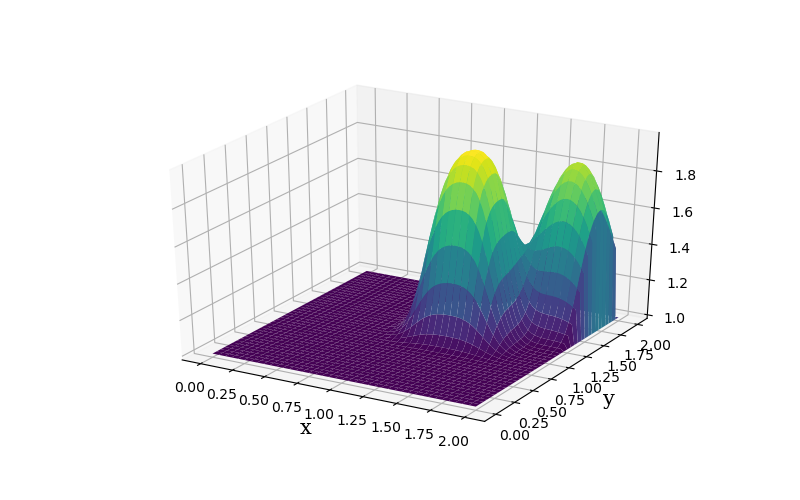

In [31]:
fig = plt.figure(figsize=(8, 5), dpi=100)

ax = fig.gca(projection='3d')
surf2 = ax.plot_surface(X, Y, u[:], cmap=plt.cm.viridis)
ax.set_xlabel('x', family='serif', fontsize=15)
ax.set_ylabel('y', family='serif', fontsize=15)

plt.savefig('Convecção linear 2D - Arrays.png')

### 2.2. Convecção não linear

Agora resolveremos a convecção 2D, representada pelo par de equações diferenciais acopladas abaixo:

$$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y}=0$$

$$\frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y}=0$$

Discretizando essas equações usando os métodos que aplicamos anteriormente resulta:

$$\frac{u_{i,j}^{n+1}-u_{i,j}^{n}}{\Delta t}+u_{i,j}^{n}\frac{u_{i,j}^{n}-u_{i-1,j}^{n}}{\Delta x}+v_{i,j}^{n}\frac{u_{i,j}^{n}-u_{i,j-1}^{n}}{\Delta y}=0$$

$$\frac{v_{i,j}^{n+1}-v_{i,j}^{n}}{\Delta t}+u_{i,j}^{n}\frac{v_{i,j}^{n}-v_{i-1,j}^{n}}{\Delta x}+v_{i,j}^{n}\frac{v_{i,j}^{n}-v_{i,j-1}^{n}}{\Delta y}=0$$

Reorganizando as duas equações, resolvemos para $u_{i,j}^{n+1}$ e $v_{i,j}^{n+1}$, respectivamente. Note que essas equações também são acopladas.

$$\boxed{u_{i,j}^{n+1}=u_{i,j}^{n}-u_{i,j}\frac{\Delta t}{\Delta x}(u_{i,j}^{n}-u_{i-1,j}^{n})-v_{i,j}^{n}\frac{\Delta t}{\Delta y}(u_{i,j}^{n}-u_{i,j-1}^{n})}$$

$$\boxed{v_{i,j}^{n+1}=v_{i,j}^{n}-u_{i,j}\frac{\Delta t}{\Delta x}(v_{i,j}^{n}-v_{i-1,j}^{n})-v_{i,j}^{n}\frac{\Delta t}{\Delta y}(v_{i,j}^{n}-v_{i,j-1}^{n})}$$

#### 2.2.1. Condições iniciais

As condições iniciais são as mesmas que usamos para a convecção 1D, porém aplicadas nas direções $x$ e $y$:

$$u, v= \left\{\begin{matrix} 2,& \mathrm{se }& x,y\in(0.5,1)\times(0.5,1) \\ 1,& \mathrm{se }& \text{caso contrário}\end{matrix} \right.$$ 

#### 2.2.2. Condições de contorno

As condições de contorno mantêm $u$ e $v$ iguais ao longo dos limites da grade:

$$u=1,v=1 \text{ para}\left\{\begin{matrix} x=0,2 & \\ y=0,2 & \end{matrix} \right.$$

Agora vamos implementar essas equações computacionalmente. Começamos com a nossa função chapéu:

In [32]:
nx = 101
ny = 101
nt = 80
c = 1
dx = 2/(nx-1)
dy = 2/(ny-1)
sigma = .2
dt = sigma*dx

x = np.linspace(0,2,nx)
y = np.linspace(0,2,ny)

u = np.ones((ny,nx))
v = np.ones((ny,nx))
un = np.ones((ny,nx))
vn = np.ones((ny,nx))


# Atribuímos as condições iniciais:
u[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
v[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2

Agora vamos ao plot:

<IPython.core.display.Javascript object>


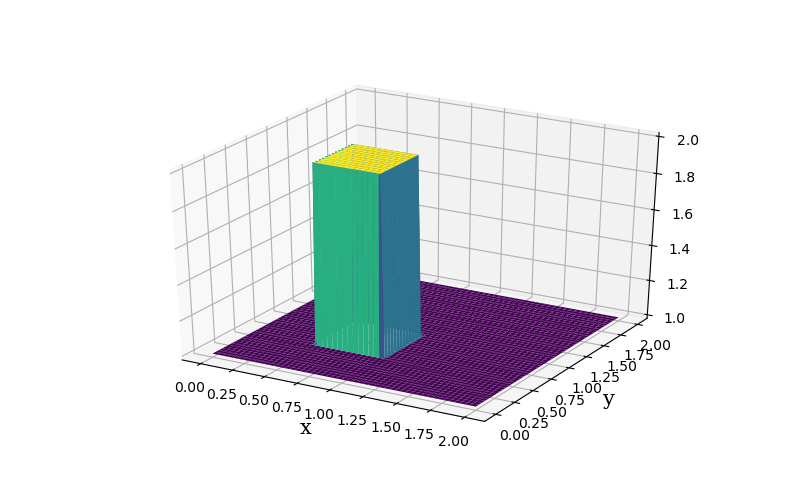

In [33]:
fig = plt.figure(figsize=(8, 5), dpi=100)

ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x, y)

ax.plot_surface(X, Y, u, cmap=plt.cm.viridis, rstride=2, cstride=2)
ax.set_xlabel('x', family='serif', fontsize=15)
ax.set_ylabel('y', family='serif', fontsize=15)

plt.savefig('Convecção não linear 2D - Função chapéu.png')

Agora vamos gerar um loop em torno do número de passos no tempo:

In [34]:
for n in range(nt + 1): 
    un = u.copy()
    vn = v.copy()
    u[1:,1:] = (un[1:, 1:] - (un[1:, 1:] * c * dt / dx * (un[1:, 1:] - un[1:, :-1])) -
                  vn[1:, 1:] * c * dt / dy * (un[1:, 1:] - un[:-1, 1:]))
    v[1:,1:] = (vn[1:, 1:] - (un[1:, 1:] * c * dt / dx * (vn[1:, 1:] - vn[1:, :-1])) - 
                 vn[1:, 1:] * c * dt / dy * (vn[1:, 1:] - vn[:-1, 1:]))
    
    u[0,:] = 1
    u[-1,:] = 1
    u[:,0] = 1
    u[:,-1] = 1
    
    v[0,:] = 1
    v[-1,:] = 1
    v[:,0] = 1
    v[:,-1] = 1

Novamente, vamos ao plot:

<IPython.core.display.Javascript object>


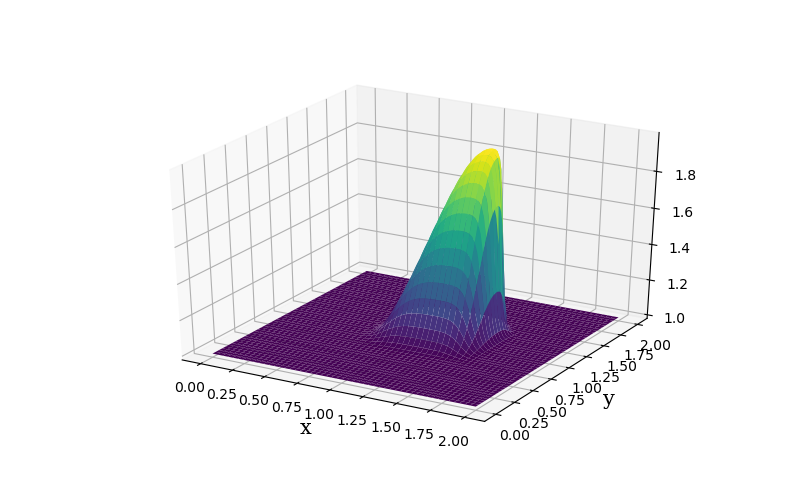

In [35]:
fig = plt.figure(figsize=(8, 5), dpi=100)

ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x, y)

ax.plot_surface(X, Y, u, cmap=plt.cm.viridis, rstride=2, cstride=2)
ax.set_xlabel('x', family='serif', fontsize=15)
ax.set_ylabel('y', family='serif', fontsize=15)

plt.savefig('Convecção não linear 2D (u).png')

<IPython.core.display.Javascript object>


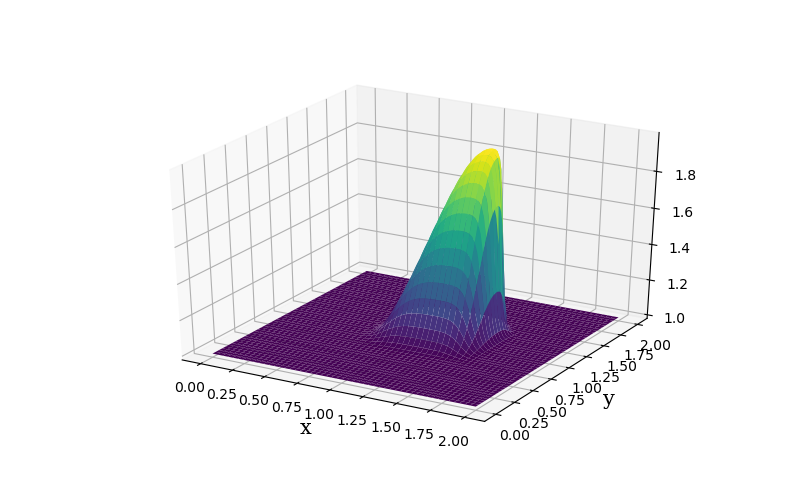

In [36]:
fig = plt.figure(figsize=(8, 5), dpi=100)
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x, y)

ax.plot_surface(X, Y, v, cmap=plt.cm.viridis, rstride=2, cstride=2)
ax.set_xlabel('x', family='serif', fontsize=15)
ax.set_ylabel('y', family='serif', fontsize=15)

plt.savefig('Convecção não linear 2D (v).png')

Note que tanto para $u$ quanto para $v$, as ondas são iguais, como já era de se esperar.

### 2.3. Difusão

Considere a equação da difusão bidimensional:

$$\frac{\partial u}{\partial t}=\nu\frac{\partial^{2}u}{\partial x^{2}}+\nu\frac{\partial^{2}u}{\partial y^{2}}$$

Relembre que desenvolvemos um método para discretizar derivadas de segunda ordem na seção 1.3, ao investigar a difusão unidimensional. Vamos usar o mesmo esquema aqui, com nossa diferença retroativa no tempo e duas derivadas de segunda ordem:

$$\frac{u_{i,j}^{n+1}-u_{i,j}^{n}}{\Delta t}=\nu\frac{u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}}{\Delta x^{2}}+\nu\frac{u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}}{\Delta y^{2}}$$

Novamente, reorganizamos nossa equação discretizada e a resolvemos para $u_{i,j}^{n+1}$:

$$\boxed{u_{i,j}^{n+1}=u_{i,j}^{n}+\frac{\nu\Delta t}{\Delta x^{2}}(u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n})+\frac{\nu\Delta t}{\Delta y^{2}}(u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n})}$$

Agora vamos implementar computacionalmente nossa equação discretizada:

In [37]:
nx = 31
ny = 31
nt = 17
nu = .05
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .25
dt = sigma * dx * dy / nu

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u = np.ones((ny,nx))  
un = np.ones((ny,nx))

# Atribuímos as condições iniciais:
u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2  

Agora vamos ao plot:

<IPython.core.display.Javascript object>


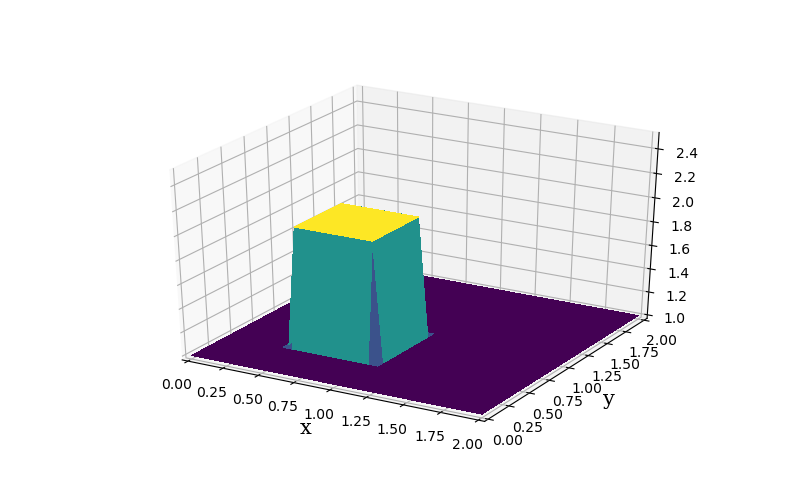

In [38]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x, y)
surf = ax.plot_surface(X, Y, u, rstride=1, cstride=1, cmap=plt.cm.viridis, linewidth=0, antialiased=False)

ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_zlim(1, 2.5)

ax.set_xlabel('x', family='serif', fontsize=15)
ax.set_ylabel('y', family='serif', fontsize=15)

plt.savefig('Difusão 2D - Função chapéu.png')

Vamos definir uma função para implementar a difusão em `nt` passos de tempo:

In [39]:
def diffuse(nt):
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2  
    
    for n in range(nt + 1): 
        un = u.copy()
        u[1:-1,1:-1] = (un[1:-1,1:-1] + nu * dt / dx**2 * 
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) + nu * dt / dy**2 * 
                        (un[2:,1: -1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1]))
        u[0,:] = 1
        u[-1,:] = 1
        u[:,0] = 1
        u[:,-1] = 1

    
    fig = plt.figure(figsize=(8,5))
    
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, u[:], rstride=1, cstride=1, cmap=plt.cm.viridis, linewidth=0, antialiased=True)
    
    ax.set_zlim(1, 2.5)
    ax.set_xlabel('x', family='serif', fontsize=15)
    ax.set_ylabel('y', family='serif', fontsize=15)

Vamos plotar algumas valores para `nt`:

<IPython.core.display.Javascript object>


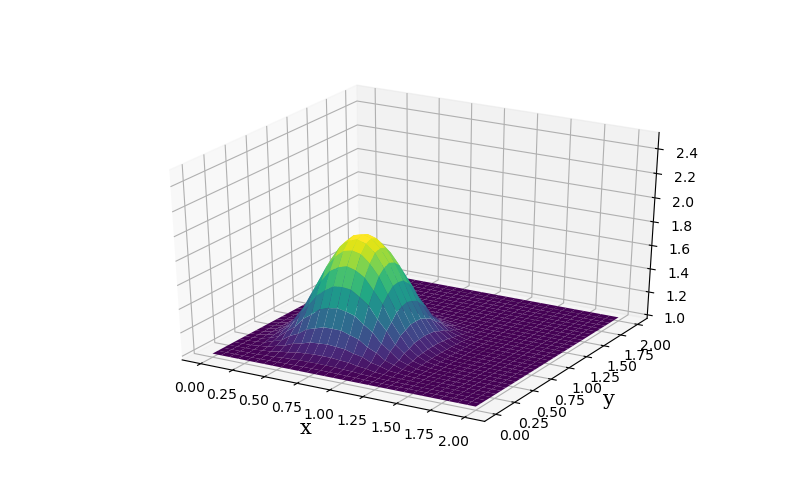

In [40]:
diffuse(10)

plt.savefig('Difusão 2D (nt = 10).png')

<IPython.core.display.Javascript object>


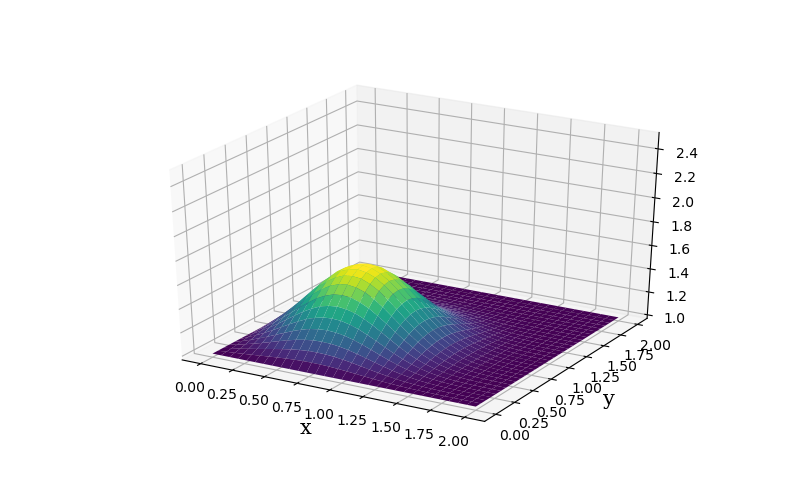

In [41]:
diffuse(30)

plt.savefig('Difusão 2D (nt = 30).png')

<IPython.core.display.Javascript object>


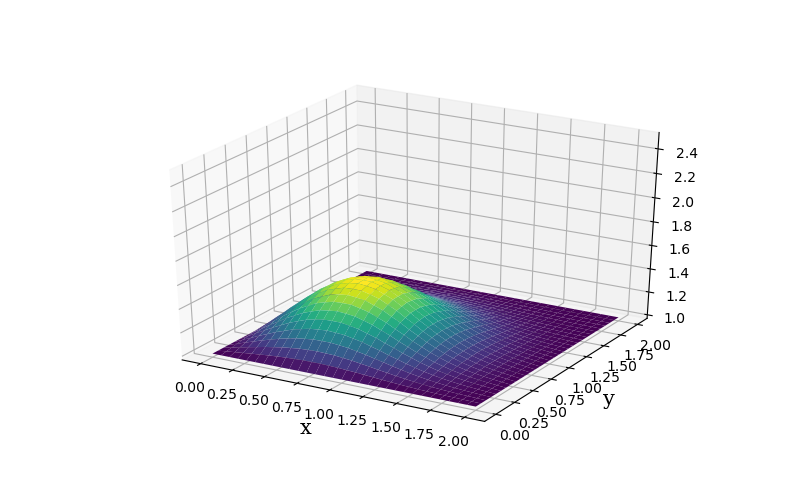

In [42]:
diffuse(50)

plt.savefig('Difusão 2D (nt = 50).png')

<IPython.core.display.Javascript object>


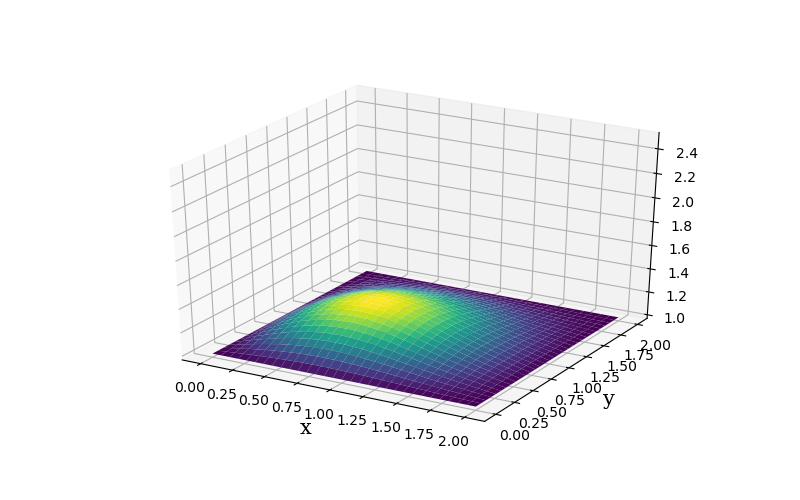

In [43]:
diffuse(100)

plt.savefig('Difusão 2D (nt = 100).png')

Note que a medida que o número de passos de tempo aumenta, nossa onda passa a se diluir cada vez mais ao longo da trajetória, ou seja, a difusão se torna cada vez mais efetiva com o tempo.

### 2.4 Equação de Burgers

Relembrando, a equação de Burgers pode gerar soluções discontínuas a partir de uma condição inicial suavizada, ou seja, pode desenvolver "choques". Vamos analisá-la em duas dimensões.

Nossa par de PDEs será o seguinte:

$$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y}=\nu\Bigg(\frac{\partial^{2}u}{\partial x^{2}}+\frac{\partial^{2}u}{\partial y^{2}}\Bigg)$$

$$\frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y}=\nu\Bigg(\frac{\partial^{2}v}{\partial x^{2}}+\frac{\partial^{2}v}{\partial y^{2}}\Bigg)$$

Sabemos como discretizar cada termo, uma vez que essa discretização foi feita anteriormente:

$$\frac{u_{i,j}^{n+1}-u_{i,j}^{n}}{\Delta t}+u_{i,j}^{n}\frac{u_{i,j}^{n}-u_{i-1,j}^{n}}{\Delta x}+v_{i,j}^{n}\frac{u_{i,j}^{n}-u_{i,j-1}^{n}}{\Delta y}=\nu\Bigg(\frac{u_{i+1,j}^n - 2u_{i,j}^n+u_{i-1,j}^n}{\Delta x^2} + \frac{u_{i,j+1}^n - 2u_{i,j}^n + u_{i,j-1}^n}{\Delta y^2}\Bigg)$$

$$\frac{v_{i,j}^{n+1}-v_{i,j}^n}{\Delta t}+u_{i,j}^n\frac{v_{i,j}^n-v_{i-1,j}^n}{\Delta x}+v_{i,j}^n\frac{v_{i,j}^n-v_{i,j-1}^n}{\Delta y}\nu\Bigg(\frac{v_{i+1,j}^n-2v_{i,j}^n+v_{i-1,j}^n}{\Delta x^2}+\frac{v_{i,j+1}^n-2v_{i,j}^n+v_{i,j-1}^n}{\Delta y^2}\Bigg)$$

Agora, basta reorganizarmos essas equações para cada uma dessas equações para uma única incógnita: os dois componentes $u$ e $v$ da solução no próximo passo de tempo:

$$u_{i,j}^{n+1}=u_{i,j}^n-\frac{\Delta t}{\Delta x}u_{i,j}^n(u_{i,j}^n - u_{i-1,j}^n)-\frac{\Delta t}{\Delta y}v_{i,j}^n (u_{i,j}^n-u_{i,j-1}^n)+\frac{\nu \Delta t}{\Delta x^2}(u_{i+1,j}^n-2u_{i,j}^n+u_{i-1,j}^n)+\frac{\nu \Delta t}{\Delta y^2} (u_{i,j+1}^n-2u_{i,j}^n+u_{i,j-1}^n)$$

$$v_{i,j}^{n+1}=v_{i,j}^n-\frac{\Delta t}{\Delta x} u_{i,j}^n (v_{i,j}^n - v_{i-1,j}^n)-\frac{\Delta t}{\Delta y}
v_{i,j}^n(v_{i,j}^n-v_{i,j-1}^n)+\frac{\nu \Delta t}{\Delta x^2}(v_{i+1,j}^n-2v_{i,j}^n+v_{i-1,j}^n)+\frac{\nu \Delta t}{\Delta y^2} (v_{i,j+1}^n-2v_{i,j}^n+v_{i,j-1}^n)$$

Agora vamos implementar esse par de equações computacionalmente. Como de costume, começamos implementando a nossa função chapéu:

In [44]:
nx = 41
ny = 41
nt = 120
c = 1
dx = 2/(nx-1)
dy = 2/(ny-1)
sigma = .0009
nu = 0.01
dt = sigma*dx*dy/nu


x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u = np.ones((ny,nx))  
v = np.ones((ny,nx))
un = np.ones((ny,nx)) 
vn = np.ones((ny,nx))
comb = np.ones((ny,nx))

# Atribuímos as condições iniciais:
u[int(.5/dy):int(1/dy+1), int(.5/dx):int(1/dx+1)] = 2 
v[int(.5/dy):int(1/dy+1), int(.5/dx):int(1/dx+1)] = 2

<IPython.core.display.Javascript object>


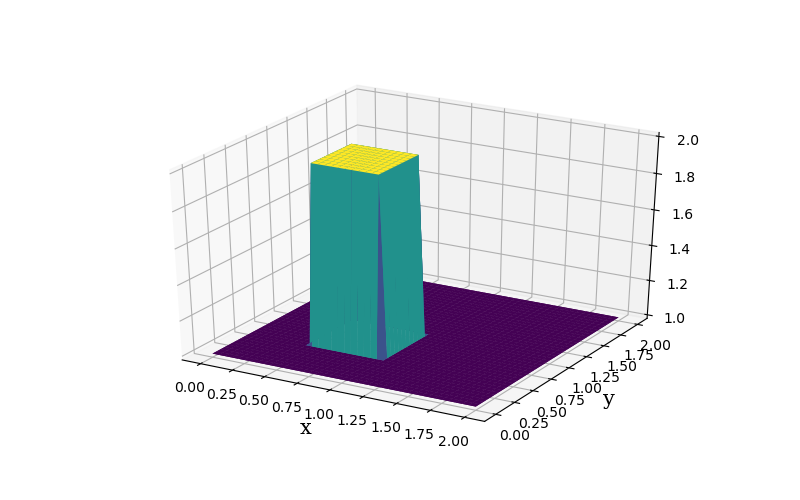

In [45]:
fig = plt.figure(figsize=(8, 5), dpi=100)

ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x, y)

ax.plot_surface(X, Y, u[:], cmap=plt.cm.viridis, rstride=1, cstride=1)
ax.plot_surface(X, Y, v[:], cmap=plt.cm.viridis, rstride=1, cstride=1)
ax.set_xlabel('x', family='serif', fontsize=15)
ax.set_ylabel('y', family='serif', fontsize=15)

plt.savefig('Eq. de Burgers 2D - Função chapéu.png')

Por fim, implementamos um for-loop ao longo do número de passos no tempo:

In [46]:
for n in range(nt + 1):
    un = u.copy()
    vn = v.copy()

    u[1:-1,1:-1] = (un[1:-1, 1:-1] - dt / dx * un[1:-1, 1:-1]*(un[1:-1, 1:-1] - un[1:-1, 0:-2]) - 
                     dt / dy * vn[1:-1, 1:-1]*(un[1:-1, 1:-1] - un[0:-2, 1:-1]) + 
                     nu * dt / dx**2*(un[1:-1,2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) + 
                     nu * dt / dy**2*(un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1]))
    
    v[1:-1,1:-1] = (vn[1:-1, 1:-1] - dt / dx * un[1:-1, 1:-1]*(vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                     dt / dy * vn[1:-1, 1:-1]*(vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) + 
                     nu * dt / dx**2*(vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                     nu * dt / dy**2*(vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1]))
     
    u[0,:] = 1
    u[-1,:] = 1
    u[:,0] = 1
    u[:,-1] = 1
    
    v[0,:] = 1
    v[-1,:] = 1
    v[:,0] = 1
    v[:,-1] = 1

Por fim, vamos plotar a equação de Burgers  bidimensional:

<IPython.core.display.Javascript object>


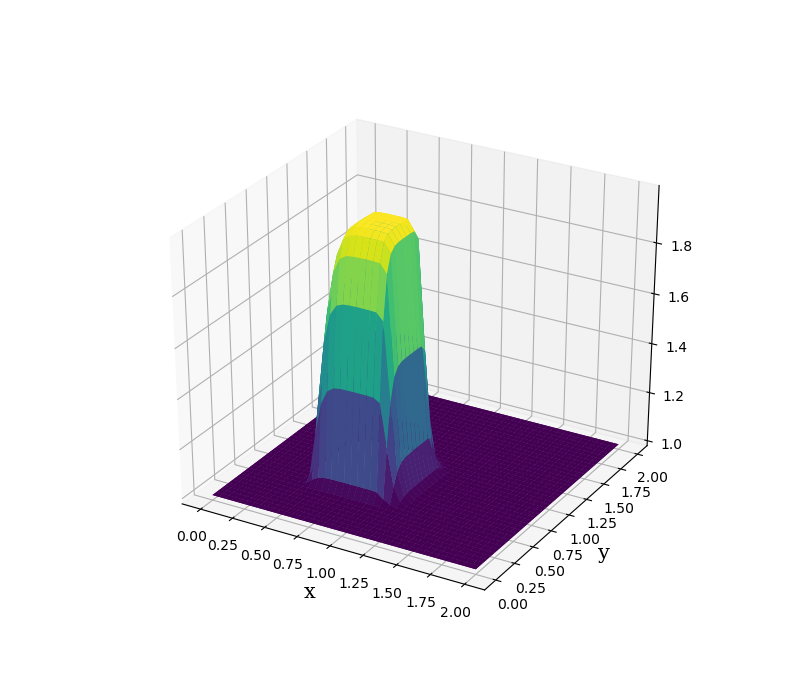

In [47]:
fig = plt.figure(figsize=(8, 7), dpi=100)

ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x, y)

ax.plot_surface(X, Y, u, cmap=plt.cm.viridis, rstride=1, cstride=1)
ax.plot_surface(X, Y, v, cmap=plt.cm.viridis, rstride=1, cstride=1)
ax.set_xlabel('x', family='serif', fontsize=15)
ax.set_ylabel('y', family='serif', fontsize=15)

plt.savefig('Eq. de Burgers 2D.png')

$\blacksquare$

### Referências

[1] *Mark Newman - Computational Physics (2013, University of Michigan)* 

[2] *Nicholas J. Giordano; Hisao Nakanishi - Computational Physics (2005, Addison-Wesley,Second Edition)*

[3] *Burgers' Equation; A. Salith (2016, Indian Institute of Space Science and Technology)*

[4] *Burgers Equation; Mikel Labdajuela (2011, BCAM Intership)*